<a href="https://colab.research.google.com/github/starrycarina/Ditchley/blob/main/industry_assignation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neo4j


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 5.7 MB/s eta 0:00:00


In [2]:
from neo4j import GraphDatabase
import openai

uri = "neo4j+s://e22e7657.databases.neo4j.io:7687"
user = "carina_clewley"
password = "Nomrbox1"

driver = GraphDatabase.driver(uri, auth=(user, password))

system_prompt = (
    "You are a researcher whose task is to assign organisations into one of multiple sector classifications. "
    "I have outlined the ontology below. When I supply you with the name of an organisation, could you please tell me which "
    "of the below sectors is the best fit. Please respond with exactly one sector name, matching one of the following options, or 'Other' if none fit:\n\n"
    "Academia\n"
    "Arts/culture\n"
    "Finance\n"
    "IGO/multilateral\n"
    "Media/journalism\n"
    "Military/defense\n"
    "NGO/nonprofit\n"
    "Politics\n"
    "Public Service\n"
    "Technology\n"
    "Other\n\n"
    "Here is the ontology:\n"
    "Academia: This encompasses institutions dedicated to advancing knowledge and learning. It includes organizations that conduct research, provide education, and foster intellectual growth. Examples: Harvard University, Oxford University, the Max Planck Society, the National Science Foundation.\n\n"
    "Arts/culture: This category covers a wide range of organizations that contribute to the artistic and cultural landscape. It includes those involved in the creation, exhibition, performance, preservation, and promotion of artistic and cultural works. Examples: The Louvre Museum, the Metropolitan Opera, the Royal Shakespeare Company, the British Film Institute.\n\n"
    "Finance: This sector encompasses firms engaged in financial activities that drive the global economy. It includes banking, investment, insurance, asset management, and accounting, as well as global management consulting practices that advise businesses on financial and strategic matters. Examples: JPMorgan Chase, Berkshire Hathaway, AIG, PwC, Boston Consulting Group.\n\n"
    "IGO/multilateral: This category includes intergovernmental organizations and multilateral institutions that operate on a global scale to address international issues and promote cooperation among nations. Examples: The United Nations, the World Trade Organization, the North Atlantic Treaty Organization, the European Union, Embassies and Consulates.\n\n"
    "Media/journalism: This sector comprises entities that play a crucial role in informing the public. It includes organizations that produce and distribute news, information, and entertainment across various media platforms. Examples: The New York Times, BBC, CNN, Reuters, The Guardian.\n\n"
    "Military/defense: This category encompasses organizations responsible for national defense and security. It includes the armed forces, defense contractors, and intelligence agencies that protect national interests and maintain security. Examples: The United States Department of Defense, BAE Systems, Lockheed Martin, the Central Intelligence Agency.\n\n"
    "NGO/nonprofit: This sector includes non-governmental organizations that operate independently of governments to address social, environmental, or humanitarian causes. They often rely on donations and volunteers to carry out their missions. Examples: Doctors Without Borders, Oxfam, the World Wildlife Fund, Human Rights Watch.\n\n"
    "Politics: This category is specifically for individuals or groups directly involved in political activity. This includes holding elected office, working for a political party, or campaigning for political causes. Examples: Members of Parliament, the Democratic Party, the Conservative Party, political action committees.\n\n"
    "Public Service: This sector encompasses government departments and agencies that provide essential public services to citizens. It includes organizations responsible for healthcare, education, infrastructure, social welfare, and other public goods, excluding political roles. Examples: The National Health Service (NHS), the Department of Education, the Environmental Protection Agency, public libraries, fire departments.\n\n"
    "Technology: This sector includes companies at the forefront of technological innovation. It encompasses those involved in the development, production, and distribution of technology products and services, including software, hardware, and biotechnology. Examples: Apple, Google, Microsoft, Amazon, Tesla, Pfizer."
)


In [ ]:
import openai

openai.api_key = "api_key_here"

def generate_ai_industry(org_name, contacts_text):
    prompt = f"""
{system_prompt}

Organisation name: {org_name}

Contacts info and themes: {contacts_text}

Please reply with only one sector from the ontology exactly as named (e.g. 'Arts/culture' or 'Technology'), or 'Other' if none apply.
"""

    response = openai.Completion.create(
        engine="gpt-4o-mini",
        prompt=prompt,
        max_tokens=100,
        temperature=0
    )
    return response.choices[0].text.strip()




Business: Already Assigned
The Ditchley Foundation: Already Assigned
Foreign, Commonwealth and Development Office (NOT IN USE): Already Assigned


AuthenticationError: Incorrect API key provided: your_api*****here. You can find your API key at https://platform.openai.com/account/api-keys.

In [ ]:
# Main Neo4j loop snippet
with driver.session() as session:
    # Get all organisations
    result = session.run("""
        MATCH (o:Organisation)
        OPTIONAL MATCH (o)-[:HAS_INDUSTRY]->(i:Industry)
        WITH o, count(i) AS industry_count
        RETURN o, elementId(o) AS eid, industry_count
        LIMIT 10
    """)

    for record in result:
        org_node = record["o"]
        org_eid = record["eid"]
        has_industry = record["industry_count"] > 0

        org_name = org_node.get("name") or f"Organisation {org_eid}"

        if has_industry:
            # Already has industry, set ai_industry property to "Already Assigned"
            session.run("""
                MATCH (o:Organisation)
                WHERE elementId(o) = $org_eid
                SET o.ai_industry = "Already Assigned"
            """, org_eid=org_eid)
            print(f"{org_name}: Already Assigned")
            continue

        # Aggregate contact bios, themes, subthemes
        contacts_result = session.run("""
            MATCH (o:Organisation)<-[:ASSOCIATED_WITH]-(c:Contact)
            WHERE elementId(o) = $org_eid
            OPTIONAL MATCH (c)-[:HAS_THEME]->(t)
            OPTIONAL MATCH (c)-[:HAS_SUBTHEME]->(s)
            RETURN collect(DISTINCT c.biography) AS bios,
                   collect(DISTINCT t.name) AS themes,
                   collect(DISTINCT s.name) AS subthemes
        """, org_eid=org_eid)

        rec = contacts_result.single()
        bios = rec["bios"] or []
        themes = rec["themes"] or []
        subthemes = rec["subthemes"] or []

        contacts_info_text = "\n".join(bios + themes + subthemes)

        # Call the LLM to get sector
        ai_industry_label = generate_ai_industry(org_name, contacts_info_text)

        # Save the property exactly as returned by the model
        session.run("""
            MATCH (o:Organisation)
            WHERE elementId(o) = $org_eid
            SET o.ai_industry = $ai_industry_label
        """, org_eid=org_eid, ai_industry_label=ai_industry_label)

        print(f"{org_name}: Predicted AI Industry -> {ai_industry_label}")


In [3]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
def fetch_data(tx):
    query = """
MATCH (c:Contact)
OPTIONAL MATCH (c)-[:HAS_THEME]->(th:Theme)
OPTIONAL MATCH (c)-[:HAS_SUBTHEME]->(sth:Subtheme)
MATCH (c)-[:ASSOCIATED_WITH]->(o:Organisation)-[:HAS_INDUSTRY]->(ind:Industry)
RETURN
  c.firstName AS contact,
  o.name AS organisation,
  ind.name AS industry,
  collect(DISTINCT th.name) AS themes,
  collect(DISTINCT sth.name) AS subthemes
    """
    return list(tx.run(query))

with driver.session(database="neo4j") as session:
    records = session.execute_read(fetch_data)

driver.close()



In [5]:
df = pd.DataFrame(records, columns=['contact', 'organisation', 'industry', 'themes', 'subthemes'])

# Unique contacts and industries
all_contacts = df['contact'].unique()
all_industries = df['industry'].unique()

# Unique themes and subthemes separately
all_themes = sorted({theme for sublist in df['themes'] for theme in sublist})
all_subthemes = sorted({subtheme for sublist in df['subthemes'] for subtheme in sublist})

# Build binary contact-theme matrix
# Explode themes only, ignoring subthemes here
df_themes = df[['contact', 'themes']].explode('themes')
df_themes = df_themes.dropna(subset=['themes'])  # remove rows with no themes
contact_theme = pd.crosstab(df_themes['contact'], df_themes['themes'])
contact_theme = (contact_theme > 0).astype(int)

# Build binary contact-subtheme matrix
df_subthemes = df[['contact', 'subthemes']].explode('subthemes')
df_subthemes = df_subthemes.dropna(subset=['subthemes'])
contact_subtheme = pd.crosstab(df_subthemes['contact'], df_subthemes['subthemes'])
contact_subtheme = (contact_subtheme > 0).astype(int)

# Build contact-industry binary matrix (same as your version)
contact_industry = df.groupby(['contact', 'industry']).size().unstack(fill_value=0)
contact_industry = (contact_industry > 0).astype(int)

# Now you have three clean matrices:
# contact_industry, contact_theme, contact_subtheme
# which you can analyze separately or join on contact as needed


In [13]:

required_industries = ['Arts/Culture', 'Military/Defence']
existing_industries = [ind for ind in required_industries if ind in contact_industry.columns]

if len(existing_industries) == len(required_industries):
    multi_industry_contacts = contact_industry[
        (contact_industry['Arts/Culture'] > 0) &
        (contact_industry['Military/Defence'] > 0)
    ].index.tolist()

    print("Contacts with records in both 'Arts/culture' and 'Military/defense' industries:")
    if multi_industry_contacts:
        for contact_name in multi_industry_contacts:
            print(f"- {contact_name}")

            # Find the organisations associated with this contact and these specific industries
            contact_orgs = df[
                (df['contact'] == contact_name) &
                (df['industry'].isin(required_industries))
            ][['organisation', 'industry']].drop_duplicates()

            if not contact_orgs.empty:
                print(f"  Associated Organisations and Industries:")
                for index, row in contact_orgs.iterrows():
                    print(f"    - Org: {row['organisation']}, Industry: {row['industry']}")
            else:
                 print(f"  No associated organisations found for these industries.")

    else:
        print("No contacts found with records in both industries.")

else:
    print(f"One or more required industries ('Arts/culture', 'Military/defense') not found in the data.")
    print(f"Available industries: {contact_industry.columns.tolist()}")



Contacts with records in both 'Arts/culture' and 'Military/defense' industries:
- Amanda
  Associated Organisations and Industries:
    - Org: Development, Concepts and Doctrine Centre, Industry: Military/Defence
    - Org: Jordan Schnitzer Family Foundation, Industry: Arts/Culture
- David
  Associated Organisations and Industries:
    - Org: The British Museum, Industry: Arts/Culture
    - Org: Oxford Preservation Trust, Industry: Arts/Culture
    - Org: Brook's Club, Industry: Arts/Culture
    - Org: The Beefsteak Club, Industry: Arts/Culture
    - Org: Marylebone Cricket Club, Industry: Arts/Culture
    - Org: NATO, Industry: Military/Defence
- Mark
  Associated Organisations and Industries:
    - Org: The Security Service, Industry: Military/Defence
    - Org: The British Museum, Industry: Arts/Culture
- Martin
  Associated Organisations and Industries:
    - Org: NATO, Industry: Military/Defence
    - Org: The British Council, Industry: Arts/Culture
- Neil
  Associated Organisatio

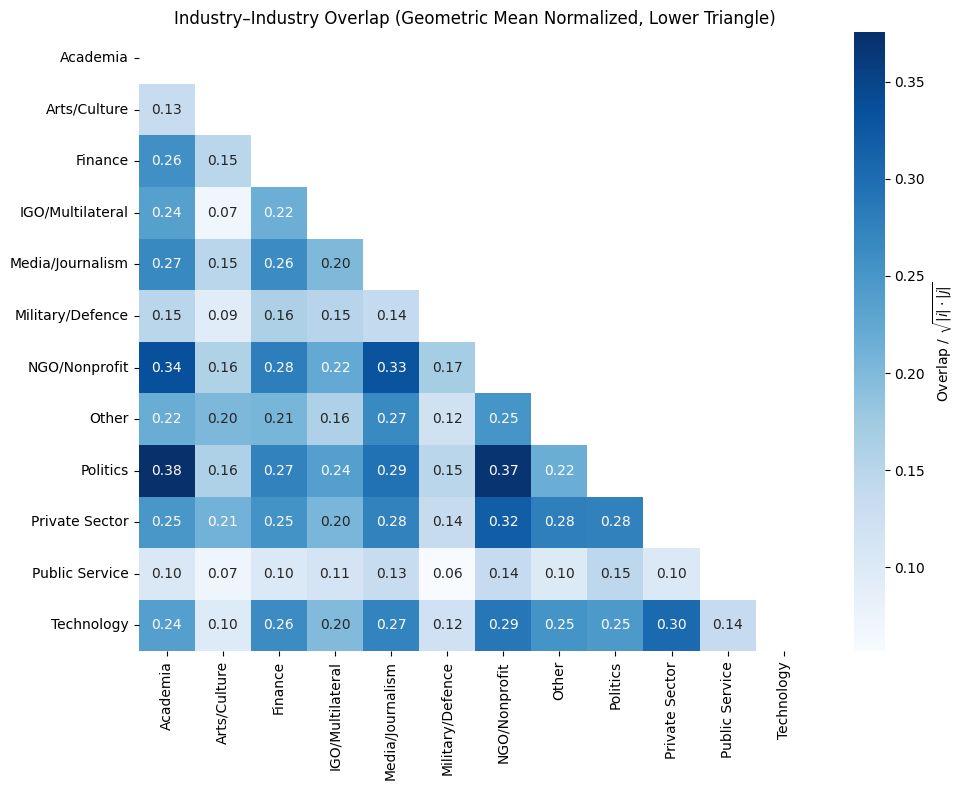

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have:
# contact_industry (rows = contacts, columns = industries, binary 0/1)

industries = contact_industry.columns.tolist()
overlap_matrix = np.zeros((len(industries), len(industries)))

for i, ind_i in enumerate(industries):
    for j, ind_j in enumerate(industries):
        if i >= j:  # only fill lower triangle & diagonal
            contacts_i = set(contact_industry.index[contact_industry[ind_i] == 1])
            contacts_j = set(contact_industry.index[contact_industry[ind_j] == 1])
            intersection = contacts_i & contacts_j
            overlap = len(intersection)
            size_i = len(contacts_i)
            size_j = len(contacts_j)
            denom = np.sqrt(size_i * size_j)
            overlap_matrix[i, j] = overlap / denom if denom > 0 else 0

# Convert to DataFrame
overlap_df = pd.DataFrame(overlap_matrix, index=industries, columns=industries)

# Create mask for upper triangle
mask = np.triu(np.ones_like(overlap_df, dtype=bool))

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    overlap_df,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
    cbar_kws={"label": r"Overlap / $\sqrt{|i| \cdot |j|}$"}
)
plt.title("Industry–Industry Overlap (Geometric Mean Normalized, Lower Triangle)")
plt.tight_layout()
plt.show()


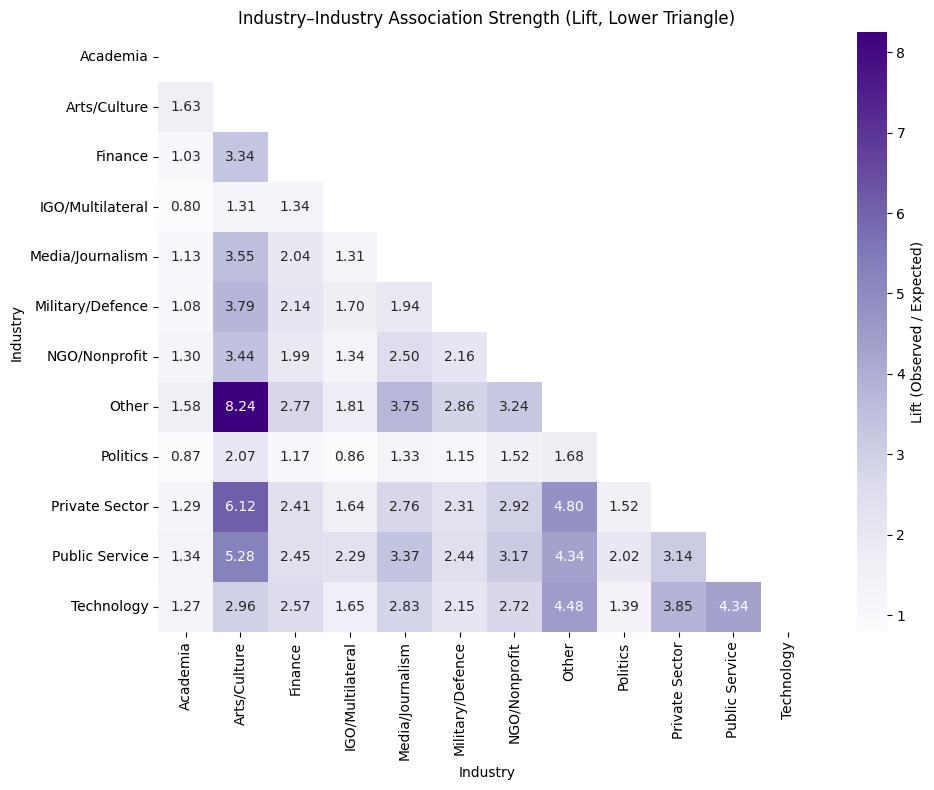

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

N = contact_industry.shape[0]  # total contacts

# co-occurrence counts
industry_cooccurrence = contact_industry.T.dot(contact_industry)

# number of contacts in each industry
industry_sizes = np.diag(industry_cooccurrence)

# convert counts into probabilities
p_i = industry_sizes / N
p_ij = industry_cooccurrence / N

# compute expected under independence
expected_ij = np.outer(p_i, p_i)

# compute lift
lift = np.zeros_like(industry_cooccurrence, dtype=float)

for i_idx, i in enumerate(industry_cooccurrence.index):
    for j_idx, j in enumerate(industry_cooccurrence.columns):
        if expected_ij[i_idx, j_idx] > 0:
            lift[i_idx, j_idx] = p_ij.iloc[i_idx, j_idx] / expected_ij[i_idx, j_idx]
        else:
            lift[i_idx, j_idx] = np.nan  # or 0 if you prefer

lift_df = pd.DataFrame(
    lift,
    index=industry_cooccurrence.index,
    columns=industry_cooccurrence.columns
)

# mask upper triangle
mask = np.triu(np.ones_like(lift_df, dtype=bool))

# plot lift heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    lift_df,
    annot=True,
    fmt=".2f",
    cmap='Purples',
    mask=mask,
    cbar_kws={"label": "Lift (Observed / Expected)"}
)
plt.title("Industry–Industry Association Strength (Lift, Lower Triangle)")
plt.xlabel("Industry")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()


In [17]:
def cramers_v(confusion_matrix):
    confusion_matrix = np.array(confusion_matrix)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    denominator = min((kcorr-1), (rcorr-1))
    if denominator == 0:
        return 0
    return np.sqrt(phi2corr / denominator)


In [20]:
import numpy as np

results = []

n_contacts = contact_industry.shape[0]

for industry in contact_industry.columns:
    p_industry = contact_industry[industry].sum() / n_contacts
    for theme in contact_theme.columns:
        p_theme = contact_theme[theme].sum() / n_contacts

        contingency = pd.crosstab(contact_industry[industry], contact_theme[theme])
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:
            chi2, p, dof, ex = chi2_contingency(contingency)
            strength = cramers_v(contingency)

            joint_count = contingency.loc[1,1] if (1 in contingency.index and 1 in contingency.columns) else 0
            p_joint = joint_count / n_contacts

            # Avoid divide-by-zero errors
            if p_industry > 0 and p_theme > 0 and p_joint > 0:
                lift = p_joint / (p_industry * p_theme)
                pmi = np.log2(lift)
            else:
                lift = np.nan
                pmi = np.nan

            results.append({
                'industry': industry,
                'theme': theme,
                'p_value': p,
                'cramers_v': strength,
                'lift': lift,
                'pmi': pmi,
                'p_industry': p_industry,
                'p_theme': p_theme,
                'p_joint': p_joint,
                'joint_count': joint_count
            })

results_df = pd.DataFrame(results)


In [21]:
%matplotlib inline


In [22]:
results_df_sorted = results_df.sort_values(by='cramers_v', ascending=False).head(10).reset_index(drop=True)
print(results_df_sorted)


           industry                                      theme       p_value  \
0  Media/Journalism  Communications / Journalism / Advertising  1.348377e-82   
1           Finance       Finance / Global Companies / Markets  4.221899e-36   
2        Technology                       Science / Technology  1.881936e-35   
3    Private Sector       Finance / Global Companies / Markets  3.627617e-23   
4     NGO/Nonprofit                        Politics / Activism  9.022547e-22   
5          Politics        Global Affairs / Defence / Commerce  2.704200e-21   
6           Finance              Economy / Production / Labour  4.632214e-21   
7          Politics                        Politics / Activism  9.903529e-20   
8    Private Sector              Economy / Production / Labour  1.931344e-18   
9     NGO/Nonprofit  Communications / Journalism / Advertising  4.780476e-15   

   cramers_v      lift       pmi  p_industry   p_theme   p_joint  joint_count  
0   0.580489  6.029920  2.592139    0.1

/tmp/ipython-input-23-3612689406.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


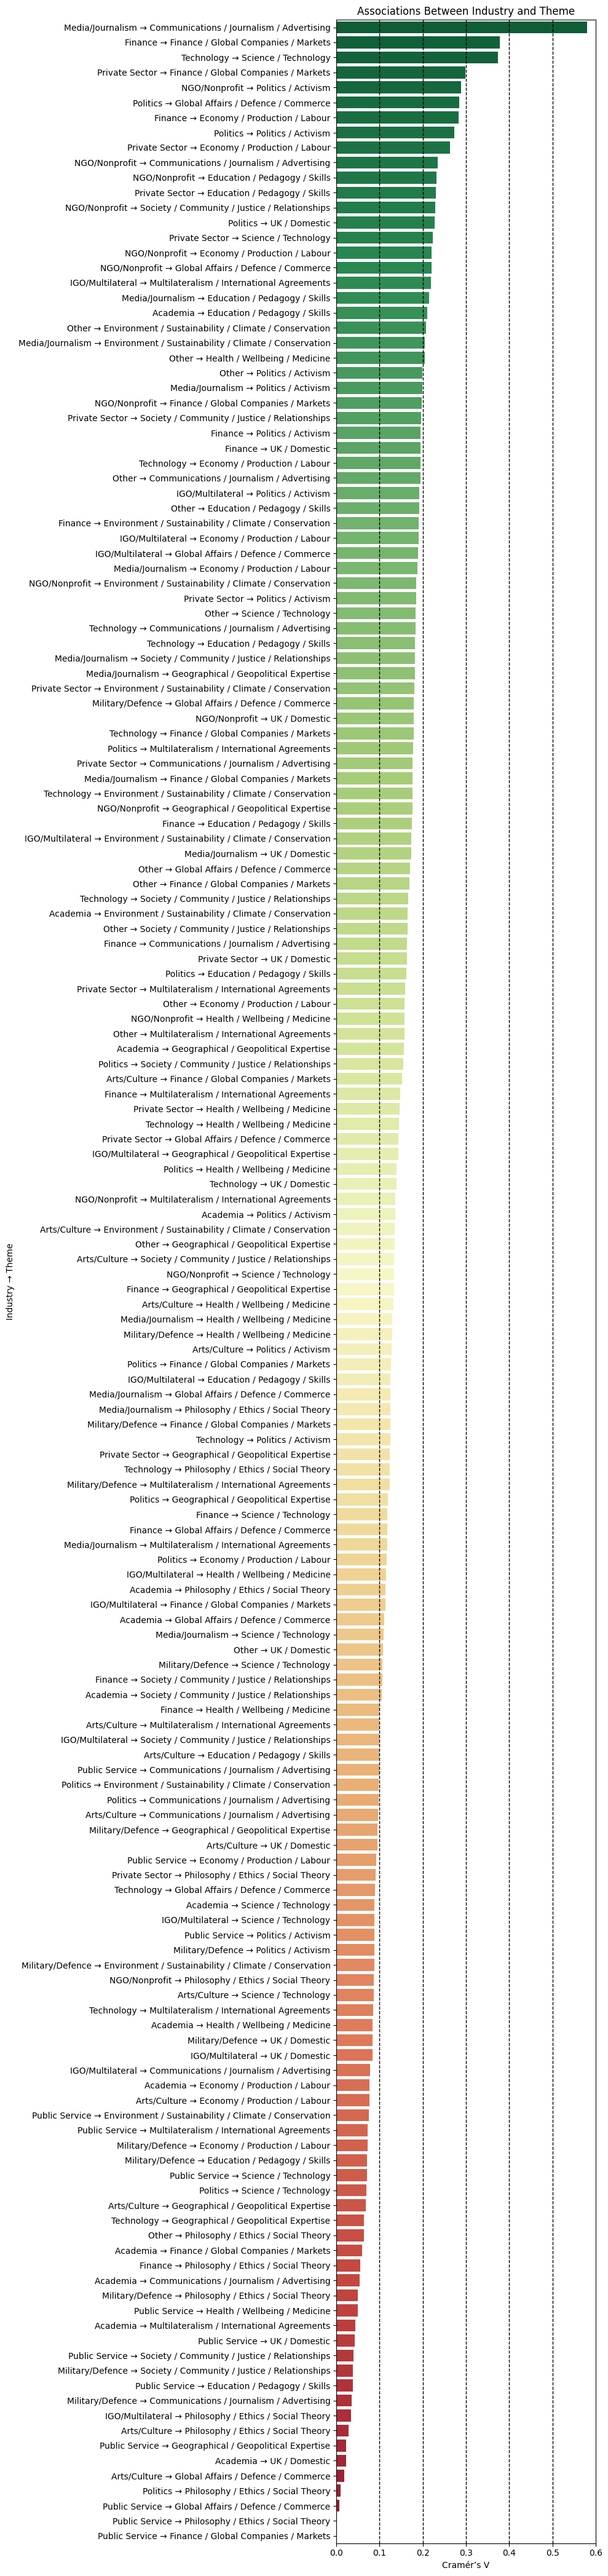

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# filter where Cramér’s V > -1 (currently no filter)
strong_results = results_df[results_df['cramers_v'] > -1].copy()

# sort descending
strong_results_sorted = strong_results.sort_values(by='cramers_v', ascending=False)

# make label
strong_results_sorted['label'] = (
    strong_results_sorted['industry'] + " → " + strong_results_sorted['theme']
)

plt.figure(figsize=(10, max(6, len(strong_results_sorted) * 0.25)))

sns.barplot(
    data=strong_results_sorted,
    x='cramers_v',
    y='label',
    palette='RdYlGn_r'
)

plt.title("Associations Between Industry and Theme")
plt.xlabel("Cramér’s V")
plt.ylabel("Industry → Theme")
plt.xlim(0, 0.6)

# Add vertical lines at 0.2 and 0.4
plt.axvline(0.1, color='black', linestyle='--', linewidth=1)
plt.axvline(0.2, color='black', linestyle='--', linewidth=1)
plt.axvline(0.3, color='black', linestyle='--', linewidth=1)
plt.axvline(0.4, color='black', linestyle='--', linewidth=1)
plt.axvline(0.5, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


In [24]:
interesting = results_df[
    (results_df['lift'] > 2) &  # Lift threshold, tweak this
    (results_df['p_industry'] < 0.3) &  # Not super-common industry
    (results_df['p_theme'] < 0.3) &  # Not super-common theme
    (results_df['p_value'] < 0.05)  # Statistically significant
].sort_values(by='pmi', ascending=False)

print(interesting.head(20))


             industry                                              theme  \
21       Arts/Culture                      Health / Wellbeing / Medicine   
105             Other                      Health / Wellbeing / Medicine   
18       Arts/Culture               Finance / Global Companies / Markets   
27       Arts/Culture                                      UK / Domestic   
17       Arts/Culture  Environment / Sustainability / Climate / Conse...   
56   Media/Journalism          Communications / Journalism / Advertising   
101             Other  Environment / Sustainability / Climate / Conse...   
140    Public Service          Communications / Journalism / Advertising   
100             Other                      Education / Pedagogy / Skills   
163        Technology                Philosophy / Ethics / Social Theory   
143    Public Service  Environment / Sustainability / Climate / Conse...   
98              Other          Communications / Journalism / Advertising   
141    Publi

In [ ]:
pip install adjustText


In [31]:
import numpy as np
from scipy.stats import chi2_contingency

results_subtheme = []

n_contacts = contact_industry.shape[0]

for industry in contact_industry.columns:
    p_industry = contact_industry[industry].sum() / n_contacts
    for subtheme in contact_subtheme.columns:
        p_subtheme = contact_subtheme[subtheme].sum() / n_contacts

        contingency = pd.crosstab(contact_industry[industry], contact_subtheme[subtheme])
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:
            chi2, p, dof, ex = chi2_contingency(contingency)
            strength = cramers_v(contingency)

            joint_count = contingency.loc[1,1] if (1 in contingency.index and 1 in contingency.columns) else 0
            p_joint = joint_count / n_contacts

            if p_industry > 0 and p_subtheme > 0 and p_joint > 0:
                lift = p_joint / (p_industry * p_subtheme)
                pmi = np.log2(lift)
            else:
                lift = np.nan
                pmi = np.nan

            results_subtheme.append({
                'industry': industry,
                'subtheme': subtheme,
                'p_value': p,
                'cramers_v': strength,
                'lift': lift,
                'pmi': pmi,
                'p_industry': p_industry,
                'p_subtheme': p_subtheme,
                'p_joint': p_joint,
                'joint_count': joint_count
            })

results_df2 = pd.DataFrame(results_subtheme)


In [26]:
import matplotlib.pyplot as plt

# Filter interesting pairs (adjust thresholds as needed)
interesting = results_df[
    (results_df['p_value'] < 0.05)
].sort_values(by='pmi', ascending=False).head(1000)  # Top 30

import plotly.express as px

# Make sure customdata is a 2D array (list of lists), each inner list corresponds to a row
customdata = interesting[['theme']].values  # shape (n, 1)

fig = px.scatter(
    interesting,
    x='pmi',
    y='cramers_v',
    size='joint_count',
    color_discrete_sequence=['steelblue'],
    hover_name='industry',
    hover_data={'joint_count': True, 'pmi': True, 'cramers_v': True, 'theme': False},  # don't duplicate theme in hover_data
    labels={
        'pmi': 'PMI (log2 Lift)',
        'cramers_v': "Cramér's V (Association Strength)"
    },
    title='Interesting Industry-Theme Associations',
    size_max=40
)

fig.update_traces(
    customdata=customdata,
    hovertemplate=(
        '<b>%{hovertext} → %{customdata[0]}</b><br>'
        'Joint Count: %{marker.size}<br>'
        'PMI: %{x:.2f}<br>'
        "Cramér's V: %{y:.2f}<extra></extra>"
    )
)

fig.show()



In [27]:
# compute expected_joint if missing
if 'expected_joint' not in results_df.columns:
    results_df['expected_joint'] = results_df['p_industry'] * results_df['p_theme']

# compute obs_over_exp if missing
if 'obs_over_exp' not in results_df.columns:
    results_df['obs_over_exp'] = results_df['p_joint'] / results_df['expected_joint']

# Filter out uninteresting rows
results_df_nonzero = results_df[
    (results_df['p_joint'] > 0) &
    (results_df['cramers_v'] > 0)
].copy()

# Stronger than expected
top_stronger_than_expected_themes = (
    results_df_nonzero.sort_values(by='obs_over_exp', ascending=False).head(5)
)

# Weaker than expected
top_weaker_than_expected_themes = (
    results_df_nonzero.sort_values(by='obs_over_exp', ascending=True).head(5)
)

print("🔷 Stronger than expected (themes):")
display(top_stronger_than_expected_themes[
    ['industry', 'theme', 'p_joint', 'expected_joint',
     'obs_over_exp', 'lift', 'pmi', 'cramers_v']
])

print("\n🔷 Weaker than expected (themes, but observed & with association):")
display(top_weaker_than_expected_themes[
    ['industry', 'theme', 'p_joint', 'expected_joint',
     'obs_over_exp', 'lift', 'pmi', 'cramers_v']
])


🔷 Stronger than expected (themes):


industry                                 theme   p_joint  \
21     Arts/Culture         Health / Wellbeing / Medicine  0.002646   
105           Other         Health / Wellbeing / Medicine  0.006947   
18     Arts/Culture  Finance / Global Companies / Markets  0.005293   
147  Public Service         Health / Wellbeing / Medicine  0.001654   
27     Arts/Culture                         UK / Domestic  0.002646   

     expected_joint  obs_over_exp      lift       pmi  cramers_v  
21         0.000294      9.010432  9.010432  3.171596   0.131904  
105        0.000834      8.325639  8.325639  3.057561   0.204394  
18         0.000833      6.354178  6.354178  2.667705   0.152529  
147        0.000260      6.353510  6.353510  2.667554   0.049358  
27         0.000419      6.317659  6.317659  2.659390   0.094867


🔷 Weaker than expected (themes, but observed & with association):


industry                                          theme  \
53   IGO/Multilateral                           Science / Technology   
123          Politics                           Science / Technology   
54   IGO/Multilateral  Society / Community / Justice / Relationships   
42   IGO/Multilateral      Communications / Journalism / Advertising   
8            Academia     Multilateralism / International Agreements   

      p_joint  expected_joint  obs_over_exp      lift       pmi  cramers_v  
53   0.029110        0.021015      1.385181  1.385181  0.470074   0.088494  
123  0.065498        0.044809      1.461727  1.461727  0.547674   0.068873  
54   0.024479        0.016548      1.479266  1.479266  0.564881   0.099204  
42   0.017532        0.011829      1.482137  1.482137  0.567679   0.078109  
8    0.046973        0.031333      1.499148  1.499148  0.584143   0.043438

In [28]:
results2 = []

for industry in contact_industry.columns:
    for subtheme in contact_subtheme.columns:
        contingency = pd.crosstab(contact_industry[industry], contact_subtheme[subtheme])
        # check that both variables actually vary (both 0 and 1 present)
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:
            chi2, p, dof, ex = chi2_contingency(contingency)
            strength = cramers_v(contingency)
            results2.append({
                'industry': industry,
                'subtheme': subtheme,
                'p_value': p,
                'cramers_v': strength
            })

if results2:
    results_df2 = pd.DataFrame(results2).sort_values('cramers_v', ascending=False)
    print(results_df2.head())
else:
    print("No valid industry-theme pairs with variation.")

              industry                        subtheme       p_value  \
456   Media/Journalism                Reporting / news  8.424293e-82   
1056        Technology                              AI  1.524731e-39   
240            Finance  Markets, hedge funds & banking  2.006494e-33   
1134        Technology                        Software  2.657023e-30   
1083        Technology                Ethics / privacy  2.015936e-23   

      cramers_v  
456    0.577612  
1056   0.396130  
240    0.362477  
1134   0.344059  
1083   0.299567  


/tmp/ipython-input-29-2352125098.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




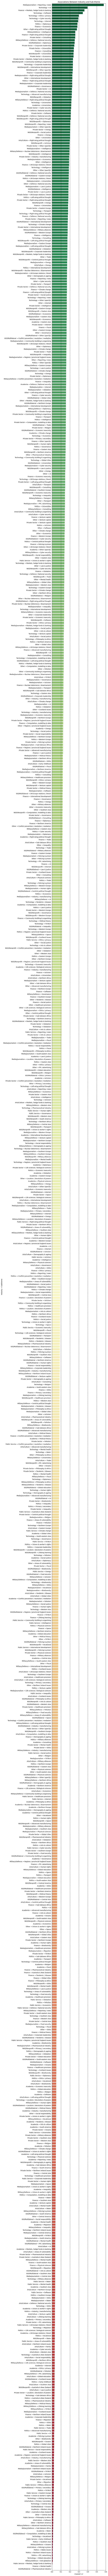

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# filter where Cramér’s V > -1 (currently no filter)
strong_results = results_df2[results_df2['cramers_v'] > 0].copy()

# sort descending
strong_results_sorted = strong_results.sort_values(by='cramers_v', ascending=False)

# make label
strong_results_sorted['label'] = (
    strong_results_sorted['industry'] + " → " + strong_results_sorted['subtheme']
)

plt.figure(figsize=(10, max(6, len(strong_results_sorted) * 0.25)))

sns.barplot(
    data=strong_results_sorted,
    x='cramers_v',
    y='label',
    palette='RdYlGn_r'
)

plt.title("Associations Between Industry and Sub-theme")
plt.xlabel("Cramér’s V")
plt.ylabel("Industry → Subtheme")
plt.xlim(0, 0.6)

# Add vertical lines at 0.2 and 0.4
plt.axvline(0.1, color='black', linestyle='--', linewidth=1)
plt.axvline(0.2, color='black', linestyle='--', linewidth=1)
plt.axvline(0.3, color='black', linestyle='--', linewidth=1)
plt.axvline(0.4, color='black', linestyle='--', linewidth=1)
plt.axvline(0.5, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


In [32]:
# @title Default title text
import matplotlib.pyplot as plt
import plotly.express as px

# Filter interesting pairs for industry-subtheme (adjust thresholds as needed)
interesting_subtheme = results_df2[
    (results_df2['p_value'] < 0.05)
].sort_values(by='pmi', ascending=True).head(10000) # Top 30

# Prepare customdata for hover: subtheme column (make sure it's 2D for plotly)
customdata_subtheme = interesting_subtheme[['subtheme']].values

fig = px.scatter(
    interesting_subtheme,
    x='pmi',
    y='cramers_v',
    size='joint_count',
    color_discrete_sequence=['steelblue'],
    hover_name='industry',
    hover_data={'joint_count': True, 'pmi': True, 'cramers_v': True, 'subtheme': False},  # exclude subtheme from default hover_data
    labels={
        'pmi': 'PMI (log2 Lift)',
        'cramers_v': "Cramér's V (Association Strength)"
    },
    title='Interesting Industry-Subtheme Associations',
    size_max=40
)

fig.update_traces(
    customdata=customdata_subtheme,
    hovertemplate=(
        '<b>%{hovertext} → %{customdata[0]}</b><br>'
        'Joint Count: %{marker.size}<br>'
        'PMI: %{x:.2f}<br>'
        "Cramér's V: %{y:.2f}<extra></extra>"
    )
)

fig.show()

In [35]:
# Filter out uninteresting rows
results_df2_nonzero = results_df2[
    (results_df2['p_joint'] > 0) &
    (results_df2['cramers_v'] > 0)
].copy()

results_df2.head()

if 'obs_over_exp' not in results_df2.columns:
    results_df2['obs_over_exp'] = results_df2['p_joint'] / results_df2['expected_joint']

# Stronger than expected
top_stronger_than_expected = (
    results_df2_nonzero.sort_values(by='obs_over_exp', ascending=False).head(10)
)

# Weaker than expected
top_weaker_than_expected = (
    results_df2_nonzero.sort_values(by='obs_over_exp', ascending=True).head(10)
)

print("🔷 Stronger than expected:")
display(top_stronger_than_expected[
    ['industry', 'subtheme', 'p_joint', 'expected_joint',
     'obs_over_exp', 'lift', 'pmi', 'cramers_v']
])

print("\n🔷 Weaker than expected (but observed & with association):")
display(top_weaker_than_expected[
    ['industry', 'subtheme', 'p_joint', 'expected_joint',
     'obs_over_exp', 'lift', 'pmi', 'cramers_v']
])


KeyError: 'expected_joint'

In [43]:
weaker_than_expected_pairs = top_weaker_than_expected_themes[['industry', 'theme']].values.tolist()



In [44]:
from collections import defaultdict

# Holds organisation -> {theme/industry: count, ...}
org_theme_counts = defaultdict(lambda: defaultdict(int))
org_contacts = defaultdict(list)

for pair in weaker_than_expected_pairs:
    if len(pair) != 2 or any(pd.isna(pair)):
        print(f"Skipping invalid pair: {pair}")
        continue

    industry, theme = pair

    # Filter original df
    relevant_contacts_df = df[
        (df['industry'] == industry) &
        (df['themes'].apply(lambda x: theme in x))
    ].copy()

    # Group by organisation & count contacts
    for org, group in relevant_contacts_df.groupby('organisation'):
        count = group.shape[0]
        if count > 1:  # only keep orgs with >1 contact for this pairing
            org_theme_counts[org][(industry, theme)] += count
            org_contacts[org].extend(group['contact'].tolist())


In [45]:
# Create summary table
rows = []
for org, theme_counts in org_theme_counts.items():
    total_contacts = sum(theme_counts.values())
    rows.append({
        'organisation': org,
        'total_contacts': total_contacts,
        'themes_and_counts': dict(theme_counts),
        'contacts': list(set(org_contacts[org]))
    })

result_df = pd.DataFrame(rows)
result_df = result_df.sort_values(by='total_contacts', ascending=False)

result_df


organisation  total_contacts  \
7     Department for Science, Innovation & Technology              20   
0                             The European Commission              19   
16                                 The Cabinet Office              18   
12                                   House of Commons              14   
4    Department for Digital, Culture, Media and Sport              12   
8        Foreign and Commonwealth Office (NOT IN USE)              12   
14                                Ministry of Defence               8   
36                          The Brookings Institution               8   
32  Organisation for Economic Cooperation and Deve...               7   
21                                 The United Nations               7   
37  The London School of Economics and Political S...               7   
26                                      Chatham House               6   
39                               University of Oxford               6   
13                                     House of Lords               6   
9        Foreign, Commonwealth and Development Office               5   
29                                 Harvard University               5   
11      Government Communications Headquarters (GCHQ)               5   
28          German Marshall Fund of the United States               4   
27              European Council on Foreign Relations               4   
24     Center for Strategic and International Studies               4   
1                             The European Parliament               4   
20                           U.S. Department of State               4   
22                     Blavatnik School of Government               4   
18                        The Prime Minister's Office               4   
6                  Department for International Trade               3   
5   Department for Environment, Food and Rural Aff...               3   
2                                              UNESCO               3   
3            United Nations Internet Governance Forum               3   
17                                    The Home Office               3   
34                                St Antony's College               3   
25                 Center for a New American Security               3   
23         Carnegie Endowment for International Peace               3   
19                          U.S. Department of Energy               2   
15                 Office of the Secretary of Defense               2   
10                              Global Affairs Canada               2   
30                              King's College London               2   
31                                New York University               2   
33                    Royal United Services Institute               2   
35                                Stanford University               2   
38                          University College London               2   

                                    themes_and_counts  \
7          {('Politics', 'Science / Technology'): 20}   
0   {('IGO/Multilateral', 'Science / Technology'):...   
16         {('Politics', 'Science / Technology'): 18}   
12         {('Politics', 'Science / Technology'): 14}   
4          {('Politics', 'Science / Technology'): 12}   
8          {('Politics', 'Science / Technology'): 12}   
14          {('Politics', 'Science / Technology'): 8}   
36  {('Academia', 'Multilateralism / International...   
32  {('Academia', 'Multilateralism / International...   
21  {('IGO/Multilateral', 'Society / Community / J...   
37  {('Academia', 'Multilateralism / International...   
26  {('Academia', 'Multilateralism / International...   
39  {('Academia', 'Multilateralism / International...   
13          {('Politics', 'Science / Technology'): 6}   
9           {('Politics', 'Science / Technology'): 5}   
29  {('Academia', 'Multilateralism / International...   
11          {('Politics', 'Science / Technology'): 5}   
28  {('Academia', 'Mu